Optimal Total Distance: 80.0 

Optimal Tour: [(1, 3), (3, 4), (4, 2), (2, 1)]




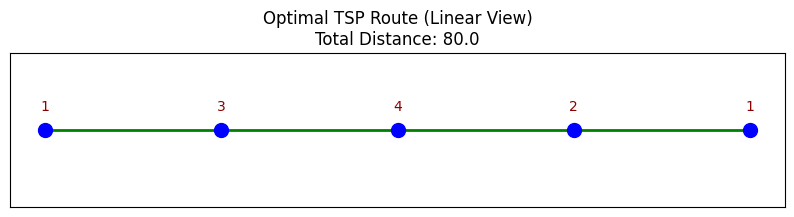

In [8]:
#!pip install pulp
import matplotlib.pyplot as plt
from pulp import *
import numpy as np

def solve_tsp_with_pulp(distance_matrix, show_route=True, show_model=False):
    """
    Solve the Traveling Salesman Problem (TSP) using linear programming with PuLP.

    This function sets up and solves a TSP instance using the PuLP library, where the goal is to find
    the shortest possible route that visits each city exactly once and returns to the starting city.

    Parameters:
    - distance_matrix (2D list or numpy array): Matrix of distances between cities.
    - show_route (bool): If True, displays a plot of the optimal route after solving the TSP. Defaults to True.
    - show_model (bool): If True, prints the linear programming model used to solve the TSP. Defaults to False.
    """

    # Get number of cities
    n = len(distance_matrix)

    # Initialize the problem
    tsp = LpProblem("Traveling_Salesman_Problem", LpMinimize)

    # Create binary decision variables x_ij for each pair of cities (1 to n)
    x = LpVariable.dicts("x", ((i, j) for i in range(1, n+1) for j in range(1, n+1) if i != j), cat='Binary')

    # Create auxiliary variables u_i for subtour elimination
    u = LpVariable.dicts("u", (i for i in range(1, n+1)), lowBound=0, upBound=n, cat='Continuous')

    # Objective function: Minimize the total travel distance
    tsp += lpSum(distance_matrix[i-1][j-1] * x[i, j] for i in range(1, n+1) for j in range(1, n+1) if i != j), "Total_Distance"

    # Constraints
    # 1. Each city must have exactly one outgoing edge
    for i in range(1, n+1):
        tsp += lpSum(x[i, j] for j in range(1, n+1) if i != j) == 1, f"Outflow_Constraint_{i}"

    # 2. Each city must have exactly one incoming edge
    for j in range(1, n+1):
        tsp += lpSum(x[i, j] for i in range(1, n+1) if i != j) == 1, f"Inflow_Constraint_{j}"

    # 3. Subtour elimination constraints (MTZ constraints)
    for i in range(2, n+1):
        for j in range(2, n+1):
            if i != j:
                tsp += u[i] - u[j] + n * x[i, j] <= n - 1, f"Subtour_Elimination_{i}_{j}"

    # Solve the problem
    tsp.solve()

    # Retrieve and print the solution
    if tsp.status == LpStatusOptimal:
        # Find the tour by starting from city 1 and following the path
        tour = []
        current_city = 1
        visited_cities = set([current_city])

        while len(visited_cities) < n:
            for j in range(1, n+1):
                if current_city != j and value(x[current_city, j]) == 1:
                    tour.append((current_city, j))
                    visited_cities.add(j)
                    current_city = j
                    break

        # Add the last leg returning to the starting city
        for j in range(1, n+1):
            if current_city != j and value(x[current_city, j]) == 1:
                tour.append((current_city, j))
                break

        # Print the results in the specified format
        print("Optimal Total Distance:", value(tsp.objective), "\n")
        print("Optimal Tour:", tour)

        # Show the model summary if show_model is set to True
        if show_model:
            print("\nModel Summary:\n")
            print(tsp)

        print("\n")

        # Show the Optimal Route if show_route is set to True
        if show_route:
          plot_optimal_route_linear(tour, value(tsp.objective))

    else:
        print("No optimal solution found.")
        return None

def plot_optimal_route_linear(optimal_tour, total_distance):
    """
    Plots the optimal route in a line for the TSP.

    Parameters:
    - optimal_tour (list of tuples): Optimal path, e.g., [(1, 3), (3, 4), (4, 2), (2, 1)].
    - total_distance (float): Total distance of the optimal tour.
    """
    # Extract the order of cities from the optimal tour
    ordered_cities = [optimal_tour[0][0]]  # Start with the first city in the tour
    for _, next_city in optimal_tour:
        ordered_cities.append(next_city)

    # Generate positions along a line for each city in the order of the optimal tour
    x_coords = list(range(1, len(ordered_cities) + 1))
    y_coords = [1] * len(ordered_cities)  # Set a constant y-coordinate for all cities to place them in a line

    # Create a figure
    plt.figure(figsize=(10, 2))
    plt.title(f"Optimal TSP Route (Linear View)\nTotal Distance: {total_distance}")

    # Plot each city in the order of the optimal tour
    plt.scatter(x_coords, y_coords, color='blue', s=100, zorder=5)

    # Annotate each city with its index according to the ordered tour
    for i, (x, y) in enumerate(zip(x_coords, y_coords)):
        plt.text(x, y + 0.05, f'{ordered_cities[i]}', ha='center', color='darkred')

    # Plot the route by drawing lines in the order of the optimal tour
    for idx in range(len(ordered_cities) - 1):
        plt.plot([x_coords[idx], x_coords[idx + 1]], [1, 1], color='green', linestyle='-', linewidth=2)

    # Set plot limits and remove the y-axis for a clean linear view
    plt.ylim(0.8, 1.2)
    plt.xlabel("Cities")
    plt.gca().get_yaxis().set_visible(False)
    plt.gca().get_xaxis().set_visible(False)
    plt.show()

# Example usage
if __name__ == "__main__":
    distance_matrix = [
        [0, 10, 15, 20],
        [10, 0, 35, 25],
        [15, 35, 0, 30],
        [20, 25, 30, 0]
    ]

    solve_tsp_with_pulp(distance_matrix, show_route=True, show_model=False)